In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import time
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

In [3]:
categorical_features = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

numerical_features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME", 
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY"

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

In [5]:
def set_categorical_dtype_to_str(
    dataframe: pd.DataFrame, 
    categorical_columns: list[str]
) -> pd.DataFrame:
    df = dataframe.copy()
    for column in categorical_columns:
        df[column] = df[column].astype('category')
    return df 

In [6]:
# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[categorical_features+numerical_features+[target]].copy()

# Set dtype of categorical features to category
training_df = set_categorical_dtype_to_str(
    dataframe=training_df, 
    categorical_columns=categorical_features
)

# Display the description of dataset
display(training_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
count,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000
mean,2.525611,6.575482,15.731372,3.976177,1328.219585,8.024030,1486.236314,9.655784,143.059972,817.382685,3.740230,12.603955
std,1.103255,3.387474,8.757283,2.003274,491.535391,4.865378,519.240116,4.977613,72.606267,597.402761,2.341283,52.502743
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,31.000000,1.000000,-96.000000
25%,2.000000,4.000000,8.000000,2.000000,910.000000,4.000000,1101.000000,6.000000,90.000000,386.000000,2.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1318.000000,8.000000,1512.000000,10.000000,125.000000,666.000000,3.000000,-2.000000
75%,3.000000,9.000000,23.000000,6.000000,1735.000000,12.000000,1921.000000,14.000000,174.000000,1052.000000,5.000000,10.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,690.000000,5095.000000,11.000000,3433.000000


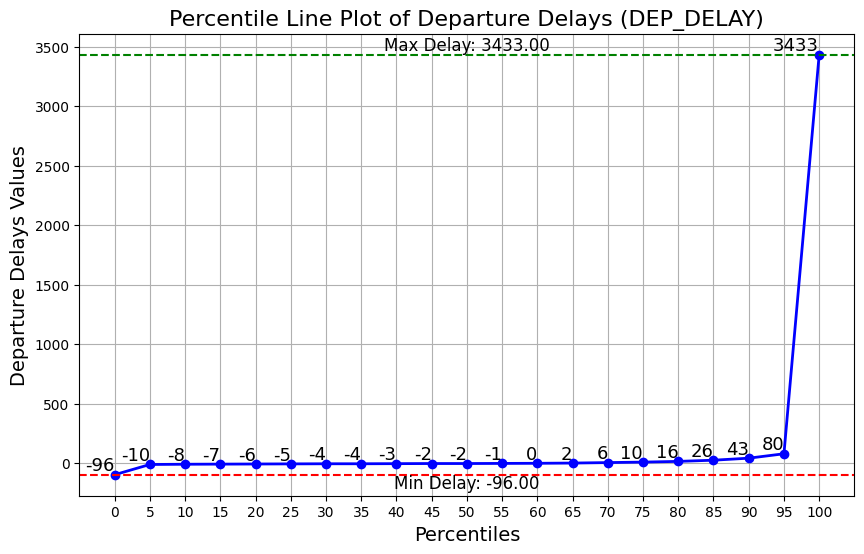

In [7]:
import matplotlib.pyplot as plt

# Calculate the percentiles at 5% intervals
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(training_df[target], percentiles)

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot the line connecting the percentiles
plt.plot(percentiles, percentile_values, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Annotate each percentile value on the line
for p, val in zip(percentiles, percentile_values):
    plt.text(p, val, f"{int(val)}", color='black', ha='right', va='bottom', fontsize=13)

# Min value of delays
min_delay = training_df[target].min()
# Max value of delays
max_delay = training_df[target].max()
# Add horizontal lines at the minimum and maximum delays
plt.axhline(y=min_delay, color='r', linestyle='--', label=f'Min Delay: {min_delay:.2f}')
plt.axhline(y=max_delay, color='g', linestyle='--', label=f'Max Delay: {max_delay:.2f}')
# Add the label text on the same line
# Adjust the x-coordinate to position the label where you want
plt.text(x=50, y=min_delay, s=f'Min Delay: {min_delay:.2f}', color='black', fontsize=12, verticalalignment='top', horizontalalignment='center')
plt.text(x=50, y=max_delay, s=f'Max Delay: {max_delay:.2f}', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='center')

# Title and labels
plt.title("Percentile Line Plot of Departure Delays (DEP_DELAY)", fontsize=16)
plt.xlabel("Percentiles", fontsize=14)
plt.ylabel("Departure Delays Values", fontsize=14)

# Set the x-axis ticks to be every 5% (already set by the percentiles)
plt.xticks(np.arange(0, 101, 5))  # Set x-axis ticks from 0 to 100 with step size of 5

# Show the plot
plt.grid(True)
plt.show()

In [8]:
edited_training_df = training_df.copy()

# Calculate the mean of values in column 'DEP_DELAY' that are >= 180
upper_mean_value = edited_training_df[edited_training_df[target] >= 180][target].mean()
# Replace values >= 180 with the mean of delay values higher than or equal to 180
edited_training_df[target] = edited_training_df[target].apply(lambda x: upper_mean_value if x >= 180 else x)

# Calculate the mean of values in column 'DEP_DELAY' that are < -15
lower_mean_value = edited_training_df[edited_training_df[target] < -15][target].mean()
# Replace values < -15 with the mean of early departure values
edited_training_df['DEP_DELAY'] = edited_training_df['DEP_DELAY'].apply(lambda x: lower_mean_value if x < -15 else x)

# Display the updated DataFrame
display(edited_training_df)

,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
0,20363,360,4732,10135,30135,42,23,11433,31295,26,43,1,1,1,6,1015,5,1209,7,114,425,2,-1.000000
1,20363,360,5430,11433,31295,26,43,10135,30135,42,23,1,1,1,6,1422,9,1548,10,86,425,2,-3.000000
2,20363,414,4671,10397,30397,13,34,14783,34783,29,64,1,1,1,6,2057,15,2149,16,112,563,3,-5.000000
3,20363,414,5009,13487,31650,27,63,11423,31423,19,61,1,1,1,6,1041,5,1153,6,72,232,1,-3.000000
4,20363,414,5083,11423,31423,19,61,10397,30397,13,34,1,1,1,6,1300,8,1610,11,130,743,3,-3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551768,20452,5292,5741,12953,31703,36,22,11066,31066,39,44,4,12,31,6,830,3,1038,5,128,479,2,-7.000000
6551769,20452,6245,3607,14321,34321,23,12,13930,30977,17,41,4,12,31,6,635,1,758,2,143,900,4,-7.000000
6551770,20452,6245,3686,13930,30977,17,41,14321,34321,23,12,4,12,31,6,1800,13,2129,16,149,900,4,-7.000000
6551771,20452,6245,3699,11003,31003,19,61,13930,30977,17,41,4,12,31,6,1508,10,1627,11,79,196,1,-10.000000


In [9]:
def evaluate_model(data_df, features_columns, target_column):
    X = data_df[features_columns].values
    y = data_df[target_column].values
    
    evaluation_results = {
        "metrics": {},
        "values": {}
    }
    actual_values, predicted_values, errors = [], [], []

    kf = KFold(n_splits=2, shuffle=True, random_state=123)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = xgb.XGBRegressor(
            enable_categorical=True,
            objective='reg:pseudohubererror',
            random_state=123,
            learning_rate=0.22,
            max_depth=8,
            min_child_weight=5,
            subsample= 0.81,
            colsample_bytree=0.79,
            n_estimators=950
        )
        model.fit(X_train, y_train)  
        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)
        
        actual_values = list(actual_values) + list(y_test)
        predicted_values = list(predicted_values) + list(y_pred)
        errors = list(errors) + list(y_test - y_pred)

    evaluation_results["values"]["actual"] = actual_values
    evaluation_results["values"]["predicted"] = predicted_values
    evaluation_results["values"]["errors"] = errors
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    evaluation_results["metrics"]["mae"] = mae
    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    evaluation_results["metrics"]["mse"] = mse
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    evaluation_results["metrics"]["rmse"] = rmse
    # R-squared (R²)
    r2 = r2_score(actual_values, predicted_values)
    evaluation_results["metrics"]["r2"] = r2
    # Adjusted R-squared (Note: requires model fit)
    n = len(actual_values)  # Number of data points
    p = len(features_columns)  # Number of predictors (features) used in the model
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    evaluation_results["metrics"]["r2_adj"] = r2_adj
    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    evaluation_results["metrics"]["mape"] = mape
    # Explained Variance Score
    explained_variance = explained_variance_score(actual_values, predicted_values)
    evaluation_results["metrics"]["explained_variance"] = explained_variance
    # Huber Loss (delta=1.0, which is common)
    # Huber Loss is not directly available in scikit-learn, thus it has to be calculated manually
    delta = np.percentile(actual_values, 95)
    huber_loss = np.mean(np.where(np.abs(np.array(actual_values) -  np.array(predicted_values)) <= delta, 
                                  0.5 * np.square(np.array(actual_values) -  np.array(predicted_values)), 
                                  delta * (np.abs(np.array(actual_values) -  np.array(predicted_values)) - 0.5 * delta)))
    evaluation_results["metrics"]["huber_loss"] = huber_loss
    # Quantile Loss (for quantile 0.5, which is the median)
    # Quantile loss is also not directly available in scikit-learn, thus it has to be calculated manually
    tau = 0.5
    quantile_loss = np.mean(np.where(np.array(actual_values) -  np.array(predicted_values) >= 0, 
                                      tau * (np.array(actual_values) -  np.array(predicted_values)), 
                                      (tau - 1) * (np.array(actual_values) -  np.array(predicted_values))))
    evaluation_results["metrics"]["quantile_loss"] = quantile_loss

    return evaluation_results

In [10]:
# Start timer
start_time = time.time()

evaluation_results = evaluate_model(
    data_df=edited_training_df, 
    features_columns=categorical_features+numerical_features, 
    target_column=target
)

print("Evaluation Results:")
print(f"Mean Absolute Error (MAE): {evaluation_results["metrics"]["mae"]}")
print(f"Mean Squared Error (MSE): {evaluation_results["metrics"]["mse"]}")
print(f"Root Mean Squared Error (RMSE): {evaluation_results["metrics"]["rmse"]}")
print(f"R-squared (R²): {evaluation_results["metrics"]["r2"]}")
print(f"Adjusted R-squared: {evaluation_results["metrics"]["r2_adj"]}")
print(f"Mean Absolute Percentage Error (MAPE): {evaluation_results["metrics"]["mape"]}%")
print(f"Explained Variance Score: {evaluation_results["metrics"]["explained_variance"]}")
print(f"Huber Loss (delta=95%={np.percentile(training_df[target], 95)}): {evaluation_results["metrics"]["huber_loss"]}")
print(f"Quantile Loss (tau=0.5): {evaluation_results["metrics"]["quantile_loss"]}")
print()

print("Result Check")
print(f"Number of training records: {len(training_df)}")
print(f"Number of actual delays: {len(evaluation_results["values"]["actual"])}")
print(f"Number of predicted delays: {len(evaluation_results["values"]["predicted"])}")
print(f"Number of registered errors: {len(evaluation_results["values"]["errors"])}")
print()

# End timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Evaluation Results:
Mean Absolute Error (MAE): 16.830848791243067
Mean Squared Error (MSE): 2067.431702857282
Root Mean Squared Error (RMSE): 45.46901915433499
R-squared (R²): 0.0016051893723780797
Adjusted R-squared: 0.0016018368809317396
Mean Absolute Percentage Error (MAPE): 8.16894804255961e+16%
Explained Variance Score: 0.06822196346750842
Huber Loss (delta=95%=80.0): 615.3706024597993
Quantile Loss (tau=0.5): 8.415424395621534

Result Check
Number of training records: 6551773
Number of actual delays: 6551773
Number of predicted delays: 6551773
Number of registered errors: 6551773

Execution time: 334.83240842819214 seconds


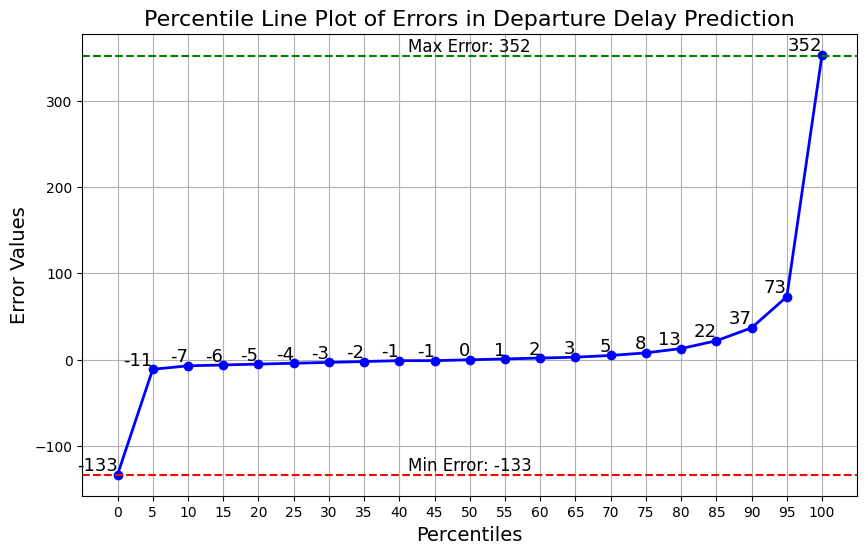

In [12]:
errors = np.array(evaluation_results["values"]["errors"])

# Calculate the percentiles at 5% intervals
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(errors, percentiles)

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot the line connecting the percentiles
plt.plot(percentiles, percentile_values, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Annotate each percentile value on the line
for p, val in zip(percentiles, percentile_values):
    plt.text(p, val, f"{int(val)}", color='black', ha='right', va='bottom', fontsize=13)

# Min value of delays
min_error = int(np.min(errors))
# Max value of delays
max_error = int(np.max(errors))
# Add horizontal lines at the minimum and maximum delays
plt.axhline(y=max_error, color='g', linestyle='--', label=f'Max Error: {max_error}')
plt.axhline(y=min_error, color='r', linestyle='--', label=f'Min Error: {min_error}')

# Add the label text on the same line
# Adjust the x-coordinate to position the label where you want
plt.text(x=50, y=min_error, s=f'Min Error: {min_error}', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='center')
plt.text(x=50, y=max_error, s=f'Max Error: {max_error}', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='center')

# Title and labels
plt.title("Percentile Line Plot of Errors in Departure Delay Prediction", fontsize=16)
plt.xlabel("Percentiles", fontsize=14)
plt.ylabel("Error Values", fontsize=14)

# Set the x-axis ticks to be every 5% (already set by the percentiles)
plt.xticks(np.arange(0, 101, 5))  # Set x-axis ticks from 0 to 100 with step size of 5

# Show the plot
plt.grid(True)
plt.show()